In [0]:
# Define the path for the dataset in DBFS
file_path = 'dbfs:/FileStore/tables/Online_Retail.csv'

# Load the dataset using Spark
data_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the dataframe
data_spark.show(5)


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [0]:
# Print the schema of the dataframe
data_spark.printSchema()

# Count the number of rows and columns
print(f"Number of rows: {data_spark.count()}")
print(f"Number of columns: {len(data_spark.columns)}")

# Show summary statistics
data_spark.describe().show()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

Number of rows: 541909
Number of columns: 8
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|         541909|           541909|            406829|     541909|
|   me

In [0]:
# Count null values in each column
from pyspark.sql.functions import col, isnan, when, count

data_spark.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in data_spark.columns]).show()


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [0]:
# Drop rows where CustomerID is null
data_spark = data_spark.filter(data_spark.CustomerID.isNotNull())


In [0]:
# Remove rows with negative Quantity or UnitPrice
data_spark = data_spark.filter((data_spark.Quantity > 0) & (data_spark.UnitPrice > 0))


In [0]:
# Fill null values in Description with "Unknown"
data_spark = data_spark.fillna({'Description': 'Unknown'})


In [0]:
# Count rows again to verify changes
print(f"Number of rows after cleaning: {data_spark.count()}")

# Show a few rows to ensure the data looks clean
data_spark.show(5)

# Recheck for null values
data_spark.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in data_spark.columns]).show()


Number of rows after cleaning: 397884
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

+---------

In [0]:
from pyspark.sql.functions import to_timestamp

# Convert InvoiceDate to timestamp
data_spark = data_spark.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "MM/dd/yyyy HH:mm"))


In [0]:
from pyspark.sql.functions import col

# Add a TotalPrice column
data_spark = data_spark.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))


In [0]:
from pyspark.sql.functions import to_timestamp

# Convert InvoiceDate to timestamp with explicit format
data_spark= data_spark.withColumn(
    "InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:mm")
)

# Verify the schema
data_spark.printSchema()



root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = false)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)



In [0]:
from pyspark.sql.functions import collect_set

# Group items by InvoiceNo
grouped_data = data_spark.groupBy("InvoiceNo").agg(collect_set("StockCode").alias("Items"))

# Show the transformed data
grouped_data.show(5, truncate=False)


+---------+---------------------------------------------------------------------------------------------------------------------+
|InvoiceNo|Items                                                                                                                |
+---------+---------------------------------------------------------------------------------------------------------------------+
|536366   |[22632, 22633]                                                                                                       |
|536367   |[22310, 22622, 21755, 22623, 84879, 84969, 21777, 22748, 48187, 22745, 21754, 22749]                                 |
|536371   |[22086]                                                                                                              |
|536374   |[21258]                                                                                                              |
|536375   |[84029E, 21730, 82483, 82482, 20679, 71053, 37370, 82486, 85123A, 84406B, 21071

In [0]:
from pyspark.ml.fpm import FPGrowth

# Initialize FP-Growth model
fp_growth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.1)

# Fit the model
model = fp_growth.fit(grouped_data)

# Display frequent itemsets
print("Frequent Itemsets:")
model.freqItemsets.show(10, truncate=False)

# Display association rules
print("Association Rules:")
model.associationRules.show(10, truncate=False)


Frequent Itemsets:
+--------+----+
|items   |freq|
+--------+----+
|[23091] |192 |
|[23504] |190 |
|[22918] |187 |
|[21935] |204 |
|[22302] |190 |
|[84050] |200 |
|[85049C]|205 |
|[22978] |197 |
|[21874] |194 |
|[22796] |212 |
+--------+----+
only showing top 10 rows

Association Rules:
+---------------+----------+------------------+------------------+--------------------+
|antecedent     |consequent|confidence        |lift              |support             |
+---------------+----------+------------------+------------------+--------------------+
|[82483]        |[82482]   |0.3889980353634578|8.229351131684474 |0.010684221886466653|
|[82483]        |[82494L]  |0.3654223968565815|8.350194646789356 |0.010036693287286855|
|[82483]        |[82486]   |0.5383104125736738|17.84609761326534 |0.0147852363479387  |
|[23254]        |[23256]   |0.7753623188405797|44.34881016281983 |0.011547593352039715|
|[22384, 22382] |[20726]   |0.5449591280653951|12.31607629427793 |0.010792143319663286|
|[22384,

In [0]:
# Group by Country and calculate total revenue
from pyspark.sql.functions import sum as _sum

country_revenue = data_spark.groupBy("Country").agg(_sum("TotalPrice").alias("TotalRevenue"))

# Sort by TotalRevenue in descending order
country_revenue_sorted = country_revenue.orderBy("TotalRevenue", ascending=False)

# Show the top 10 countries by revenue
country_revenue_sorted.show(10)


+--------------+------------------+
|       Country|      TotalRevenue|
+--------------+------------------+
|United Kingdom| 7308391.553999939|
|   Netherlands|285446.33999999997|
|          EIRE|265545.89999999997|
|       Germany| 228867.1400000001|
|        France|209024.05000000002|
|     Australia|         138521.31|
|         Spain|61577.110000000015|
|   Switzerland| 56443.94999999997|
|       Belgium| 41196.34000000001|
|        Sweden|          38378.33|
+--------------+------------------+
only showing top 10 rows



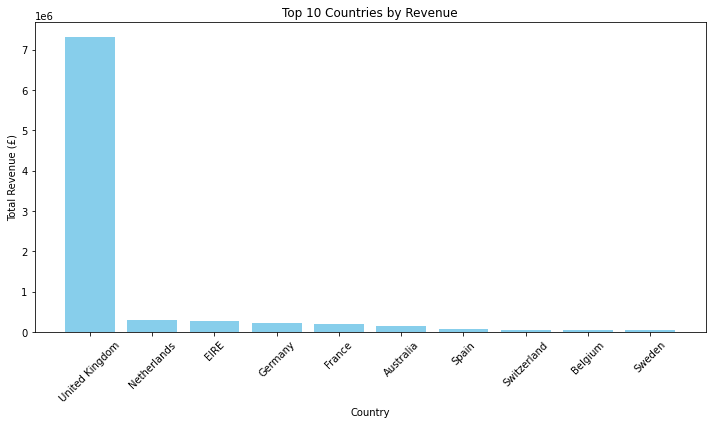

In [0]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
country_revenue_pd = country_revenue_sorted.toPandas()

# Plot top 10 countries
plt.figure(figsize=(10, 6))
plt.bar(country_revenue_pd["Country"][:10], country_revenue_pd["TotalRevenue"][:10], color="skyblue")
plt.xlabel("Country")
plt.ylabel("Total Revenue (£)")
plt.title("Top 10 Countries by Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
# Generate association rules from frequent itemsets
association_rules = model.associationRules

# Show the first few association rules to verify
association_rules.show(10)


+---------------+----------+------------------+------------------+--------------------+
|     antecedent|consequent|        confidence|              lift|             support|
+---------------+----------+------------------+------------------+--------------------+
|        [82483]|   [82482]|0.3889980353634578| 8.229351131684474|0.010684221886466653|
|        [82483]|  [82494L]|0.3654223968565815| 8.350194646789356|0.010036693287286855|
|        [82483]|   [82486]|0.5383104125736738| 17.84609761326534|  0.0147852363479387|
|        [23254]|   [23256]|0.7753623188405797| 44.34881016281983|0.011547593352039715|
| [22384, 22382]|   [20726]|0.5449591280653951| 12.31607629427793|0.010792143319663286|
| [22384, 22382]|   [20728]|0.6049046321525886|11.604650769204733|0.011979279084826246|
| [22384, 22382]|   [20725]|0.6839237057220708| 9.832796054648114|0.013544139866177423|
| [22384, 22382]|   [22383]|0.5395095367847411| 9.585993035181996|0.010684221886466653|
| [22384, 22382]|   [20727]|0.61

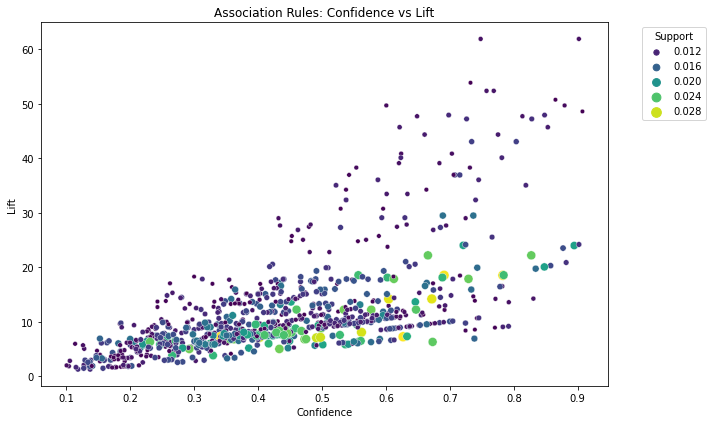

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert association rules to Pandas DataFrame
association_rules_pd = association_rules.toPandas()

# Create a scatter plot of Confidence vs Lift
plt.figure(figsize=(10, 6))
sns.scatterplot(x="confidence", y="lift", data=association_rules_pd, hue="support", palette="viridis", size="support", sizes=(20, 100))
plt.title("Association Rules: Confidence vs Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.legend(title="Support", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [0]:
from pyspark.ml.feature import VectorAssembler

# Select relevant columns for clustering
customer_features = data_spark.select("TotalPrice", "Quantity", "UnitPrice")

# Assemble features into a vector column
vec_assembler = VectorAssembler(inputCols=["TotalPrice", "Quantity", "UnitPrice"], outputCol="features")
data_vectorized = vec_assembler.transform(customer_features)


In [0]:
from pyspark.ml.clustering import KMeans

# Initialize KMeans with 3 clusters
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")

# Fit the model
kmeans_model = kmeans.fit(data_vectorized)

# Make predictions (assign clusters)
clustered_data = kmeans_model.transform(data_vectorized)

# Show the resulting clusters with customer details
clustered_data.select("TotalPrice", "Quantity", "UnitPrice", "cluster").show(10)


+------------------+--------+---------+-------+
|        TotalPrice|Quantity|UnitPrice|cluster|
+------------------+--------+---------+-------+
|15.299999999999999|       6|     2.55|      0|
|             20.34|       6|     3.39|      0|
|              22.0|       8|     2.75|      0|
|             20.34|       6|     3.39|      0|
|             20.34|       6|     3.39|      0|
|              15.3|       2|     7.65|      0|
|              25.5|       6|     4.25|      0|
|11.100000000000001|       6|     1.85|      0|
|11.100000000000001|       6|     1.85|      0|
|             54.08|      32|     1.69|      0|
+------------------+--------+---------+-------+
only showing top 10 rows



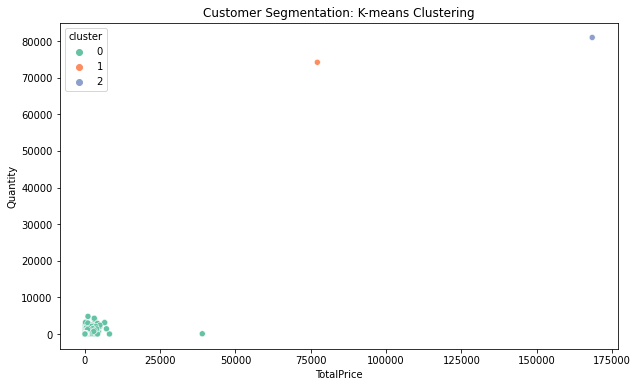

In [0]:
# Convert to Pandas DataFrame for visualization
clustered_data_pd = clustered_data.select("TotalPrice", "Quantity", "UnitPrice", "cluster").toPandas()

# Plotting the clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x="TotalPrice", y="Quantity", hue="cluster", data=clustered_data_pd, palette="Set2")
plt.title("Customer Segmentation: K-means Clustering")
plt.xlabel("TotalPrice")
plt.ylabel("Quantity")
plt.show()
